# Анализ работы ЭЦН. Продолжение

версия 0.1 от 17.5.20


In [1]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
import pandas as pd
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Описание функции  `ESP_p_atma`
Производит расчет ЭЦН и выдает много информации

Функция возвращает несколько tuples (неизменяемых списков python), при этом количество данных в выводе может варьироваться по усмотрению пользователя


In [3]:
help(UniflocVBA.ESP_p_atma)

Help on method ESP_p_atma in module unifloc_vba_python_api.python_api:

ESP_p_atma(qliq_sm3day, fw_perc, p_calc_atma, num_stages=1, freq_Hz=50, pump_id=674, str_PVT='gamma_gas:0,900;gamma_oil:0,750;gamma_wat:1,000;rsb_m3m3:100,000;rp_m3m3:-1,000;pb_atma:-1,000;tres_C:90,000;bob_m3m3:-1,000;muob_cP:-1,000;PVTcorr:0;ksep_fr:0,000;pksep_atma:-1,000;tksep_C:-1,000; ', t_intake_C=50, t_dis_C=50, calc_along_flow=1, ESP_gas_correct=1, c_calibr=1, dnum_stages_integrate=1, out_curves_num_points=20, num_value=0) method of unifloc_vba_python_api.python_api.API instance
     ========== description ============== 
    функция расчета давления на выходе/входе ЭЦН в рабочих условиях 
            
     ==========  arguments  ============== 
    
         qliq_sm3day - дебит жидкости на поверхности    
    
         fw_perc - обводненность    
    
         p_calc_atma - давление для которого делается расчет  либо давление на приеме насоса  либо давление на выкиде насоса    
    
         num_stages - 

Зададим исходные данные по флюиду с помощью словаря

Обычная стандартная PVT строка

In [4]:
pvt_str_data = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":100,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0,
"p_ksep_atma":-1,
"t_ksep_C":-1,
"gas_only":False
               }

In [5]:
esp_data = {"qliq_sm3day": 40,
    "fw_perc": 20,
    "p_calc_atma": 50,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":1006, # TODO что то не так с насосом 674
    "str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data),
    "t_intake_C":50,
    "t_dis_C":50,
    "calc_along_flow":1,
    "ESP_gas_correct":1,
    "c_calibr":1,
    "dnum_stages_integrate":1,
    "out_curves_num_points":20,
    "num_value":0}

Результат расчета

In [6]:
vba_result = UniflocVBA.ESP_p_atma(**esp_data)
vba_result

((77.54910591220069,
  50.0,
  50.0,
  77.54910591220069,
  50.0,
  595.6990648105393,
  15.021400082503725,
  5.0,
  2566.4697817673928,
  4719.112014582676,
  0.5438459129252842,
  0.5481778449257626,
  1.0,
  None,
  None,
  None),
 ('p_dis_atma',
  'p_int_atma',
  't_int_C',
  'p_dis_atma',
  't_dis_C',
  'head_m',
  'm_Nm',
  'length_m',
  'power_fluid_W',
  'power_ESP_W',
  'eff_ESP_d',
  'gas_frac_intake_',
  'gas_corr_',
  None,
  None,
  None),
 ('i',
  'n_stage',
  'length_m',
  'p_atma',
  't_C',
  'gas_fraction',
  'qmix_rm3day',
  'Power_fluid_W',
  'Power_ESP_W',
  'eff fluid',
  'mu_stage_cP',
  'corr_visc_h_',
  'corr_visc_q_',
  'corr_visc_pow_',
  'corr_visc_eff_',
  'gas_corr_'),
 (1,
  0.0,
  5.0,
  50.0,
  50.0,
  0.5481778449257625,
  93.68463772982962,
  0.0,
  0.0,
  0.0,
  1.1739419491532797,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0),
 (2,
  5.2631578947368425,
  4.7368421052631575,
  51.12967723315966,
  50.0,
  0.5408515099921208,
  92.26770347519815,
  123.10102081

# Подготовка инструментов для работы с данными

Сделаем функцию, чтобы работать с данными было удобнее

In [7]:
def covert_vba_result(vba_result, option=0):
    if option == 0: #возвращаем только рассчитанные давление и температуру
        result = vba_result[0][0], vba_result[0][1]
    elif option == 1:
        result = pd.DataFrame(vba_result) #возвращает необработанный DataFrame
    elif option == 2: #возвращает обработанный DataFrame с распределением свойств
        result = pd.DataFrame(vba_result)
        result.columns = result[result.index==2].iloc[0]
        bottom_border =  result[result['i'] == 'calc_from_dis'].index[0]
        result = result[result.index<bottom_border]
        result = result[result.index>2]
        result = result.set_index('n_stage')
    return result    

Только давление и температура

In [8]:
covert_vba_result(vba_result, 0)

(77.54910591220069, 50.0)

Все данные в формате DataFrame

In [9]:
covert_vba_result(vba_result, 1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,77.5491,50,50,77.5491,50,595.699,15.0214,5,2566.47,4719.11,0.543846,0.548178,1,None,None,None
1,p_dis_atma,p_int_atma,t_int_C,p_dis_atma,t_dis_C,head_m,m_Nm,length_m,power_fluid_W,power_ESP_W,eff_ESP_d,gas_frac_intake_,gas_corr_,None,None,None
2,i,n_stage,length_m,p_atma,t_C,gas_fraction,qmix_rm3day,Power_fluid_W,Power_ESP_W,eff fluid,mu_stage_cP,corr_visc_h_,corr_visc_q_,corr_visc_pow_,corr_visc_eff_,gas_corr_
3,1,0,5,50,50,0.548178,93.6846,0,0,0,1.17394,1,1,1,0,1
4,2,5.26316,4.73684,51.1297,50,0.540852,92.2677,123.101,220.54,0.558176,1.17908,1,1,1,1,1
5,3,10.5263,4.47368,52.295,50,0.532585,90.7234,247.929,443.756,0.558705,1.18457,1,1,1,1,1
6,4,15.7895,4.21053,53.4956,50,0.524152,89.2047,374.391,669.683,0.559056,1.18985,1,1,1,1,1
7,5,21.0526,3.94737,54.7318,50,0.515558,87.7129,502.424,898.411,0.559236,1.1949,1,1,1,1,1
8,6,26.3158,3.68421,56.004,50,0.506808,86.2493,631.972,1130.04,0.559247,1.19971,1,1,1,1,1
9,7,31.5789,3.42105,57.312,50,0.49791,84.8147,762.96,1364.64,0.559093,1.20427,1,1,1,1,1


DataFrame с распределением свойств по ступеням ЭЦН

In [10]:
r = covert_vba_result(vba_result, 2)
r

2,i,length_m,p_atma,t_C,gas_fraction,qmix_rm3day,Power_fluid_W,Power_ESP_W,eff fluid,mu_stage_cP,corr_visc_h_,corr_visc_q_,corr_visc_pow_,corr_visc_eff_,gas_corr_
n_stage,,,,,,,,,,,,,,,
0.000000,1,5,50,50,0.548178,93.6846,0,0,0,1.17394,1,1,1,0,1
5.263158,2,4.73684,51.1297,50,0.540852,92.2677,123.101,220.54,0.558176,1.17908,1,1,1,1,1
10.526316,3,4.47368,52.295,50,0.532585,90.7234,247.929,443.756,0.558705,1.18457,1,1,1,1,1
15.789474,4,4.21053,53.4956,50,0.524152,89.2047,374.391,669.683,0.559056,1.18985,1,1,1,1,1
21.052632,5,3.94737,54.7318,50,0.515558,87.7129,502.424,898.411,0.559236,1.1949,1,1,1,1,1
26.315789,6,3.68421,56.004,50,0.506808,86.2493,631.972,1130.04,0.559247,1.19971,1,1,1,1,1
31.578947,7,3.42105,57.312,50,0.49791,84.8147,762.96,1364.64,0.559093,1.20427,1,1,1,1,1
36.842105,8,3.15789,58.6561,50,0.488871,83.4101,895.323,1602.29,0.558776,1.20856,1,1,1,1,1
42.105263,9,2.89474,60.0363,50,0.479697,82.0364,1029,1843.1,0.558301,1.21258,1,1,1,1,1


Распределение давления вдоль ЭЦН

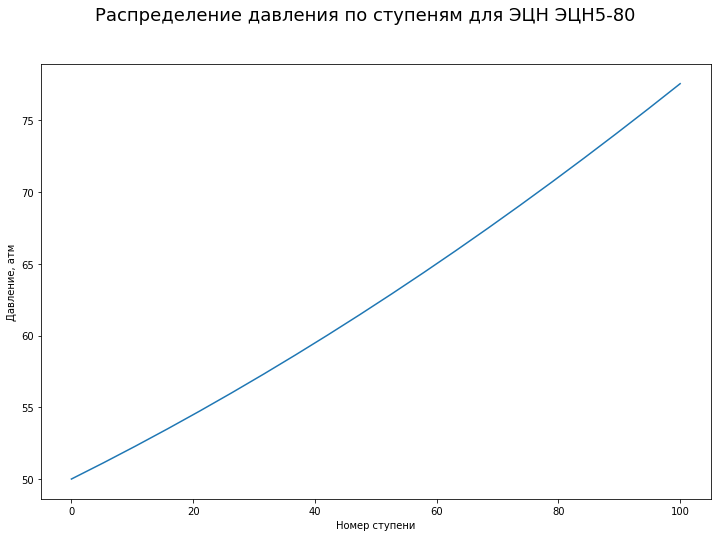

In [11]:
fig = plt.figure()
plt.plot(r.index, r['p_atma'])
plt.xlabel('Номер ступени')
plt.ylabel('Давление, атм')
fig.suptitle(f"Распределение давления по ступеням для ЭЦН {UniflocVBA.ESP_name(esp_data['pump_id'])}", fontsize = 18)
plt.show()

# Анализ напорной кривой при перекачке многофазной смеси

In [12]:
def sense_curve(esp_data, pvt_str_data, parameter_sense, range_sense,
                pvt_edit=False, parameter_to_plot='p_atma', qliq_mult_from_max=1, use_q_mix=False, result_value_type=1):
    """
    Функция для анализа чувствительности характеристики ЭЦН
    esp_data: словарь с данными ЭЦН
    pvt_str_data: словарь с PVT строкой
    parameter_sense: параметр, для которой произодится анализ чувствительности
    range_sense: диапазон, в котором будут варьироваться требуемый параметр
    pvt_edit: флаг, true - будет изменяться pvt строка, false - будет изменяться данные ЭЦН
    parameter_to_plot: параметр для оси y, давление, температура, вязкость и т.д.
    qliq_mult_from_max: множитель для правой границы дебитов, изначально дебит 
                        будет идти до максимумальной производительности насоса по ESP_rate_max_sm3day
    
    use_q_mix: True - по оси дебита будет средний дебит ГЖС в условиях ЭЦН, 
               False - по оси дебита будет дебит в поверхностных условиях
    result_value_type: тип выводимого результата
                        0 - точка для входа ЭЦН (например, давление на входе)
                        1 - точка на выходе ЭЦН (например, давелние на выходе)
                        2 - среднее значение на входе и на выходе
    """
    fig = plt.figure()
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            esp_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            esp_data[parameter_sense] = i
        
        this_qmax_m3day = UniflocVBA.ESP_rate_max_sm3day(esp_data["freq_Hz"], esp_data["pump_id"], 1)
        this_result_list = []
        this_q_liq_range = list(range(1, int(this_qmax_m3day * qliq_mult_from_max),  int(this_qmax_m3day/10)))
        this_q_mix_range = []
        for j in this_q_liq_range:    
            esp_data['qliq_sm3day'] = j
            vba_result = UniflocVBA.ESP_p_atma(**esp_data)
            r = covert_vba_result(vba_result,2)
            if result_value_type == 0:
                this_value = r[parameter_to_plot].values[0]
            elif result_value_type == 1:
                this_value = r[parameter_to_plot].values[-1]
            else:
                this_value = (r[parameter_to_plot].values[0] + r[parameter_to_plot].values[-1])/2
                
            this_result_list.append(this_value)
            
            q_mix_m3day_in = r['qmix_rm3day'].values[0]
            q_mix_m3day_out = r['qmix_rm3day'].values[-1]
            q_mix_mean = (q_mix_m3day_in + q_mix_m3day_out) / 2
            this_q_mix_range.append(q_mix_mean)
            
            
        if use_q_mix:
            plt.plot(this_q_mix_range, this_result_list, label = f"{parameter_sense} = {i}")
        else:
            plt.plot(this_q_liq_range, this_result_list, label = f"{parameter_sense} = {i}")
    plt.legend(loc='lower right')
    if use_q_mix:
        plt.xlabel("Дебит ГЖС в условиях насоса, м3/сут")
    else:
        plt.xlabel("Дебит жидкости в поверхностных условиях, м3/сут")
    plt.ylabel(parameter_to_plot)
    fig.suptitle(f"Распределение параметра {parameter_to_plot} при различный значениях дебит для " 
                 f"{UniflocVBA.ESP_name(esp_data['pump_id'])}", fontsize = 18)
    plt.show()

In [13]:
pvt_str_data = {"gamma_gas":0.6,
"gamma_oil":0.86,
"gamma_wat":1,
"rsb_m3m3":100,
"rp_m3m3":-1,
"pb_atma":-1,
"tres_C":90,
"bob_m3m3":-1,
"muob_cP":-1,
"PVTcorr":0,
"ksep_fr":0,
"p_ksep_atma":-1,
"t_ksep_C":-1,
"gas_only":False
               }

In [14]:
esp_data = {"qliq_sm3day": 40,
    "fw_perc": 20,
    "p_calc_atma": 50,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":1006, # TODO что то не так с насосом 674
    "str_PVT":UniflocVBA.PVT_encode_string(**pvt_str_data),
    "t_intake_C":50,
    "t_dis_C":0,
    "calc_along_flow":1,
    "ESP_gas_correct":1,
    "c_calibr":1,
    "dnum_stages_integrate":1,
    "out_curves_num_points":20,
    "num_value":0}

График для значения давления на выходе ЭЦН при различных значениях газосодежания нефти

В начале есть провал по причине температурных эффектов

Чем больше газонасыщенность нефти, тем меньший перепад давления способен развивать ЭЦН

Также стоит заметить, что графики смещенены друг от друга

И при одном и том же дебите жидкости в поверхностных условиях при разных rsb насос не может развивать перепад давления

Это происходит из-за того, что дебит ГЖС в условиях ЭЦН больше, чем замеренный в поверхностных условиях дебит.

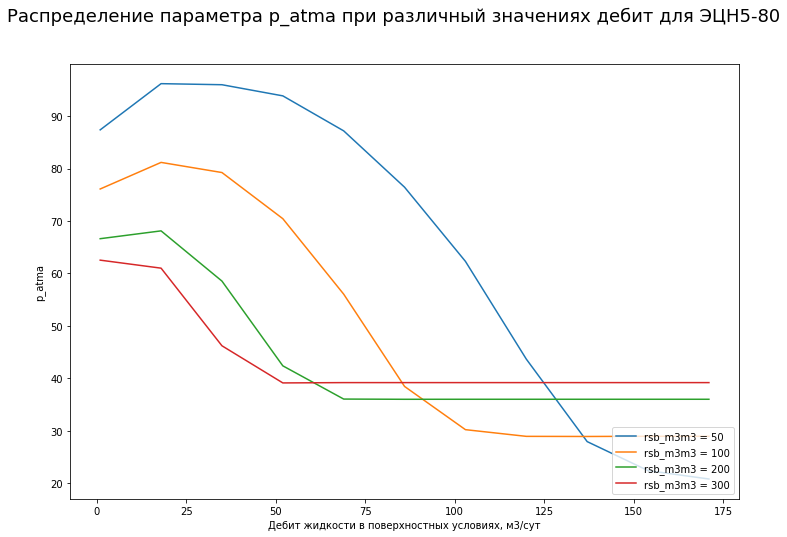

In [15]:
sense_curve(esp_data.copy(), pvt_str_data.copy(),
            'rsb_m3m3', [50, 100, 200, 300], True, 'p_atma', 
           result_value_type=1)

Нужно всегда при подборе ЭЦН использовать дебит ГЖС, в условиях ЭЦН

По графику видно, что характеристики (насос) один и тот же.

И при большем газосодержании ЭЦН развивает меньший перепад давления

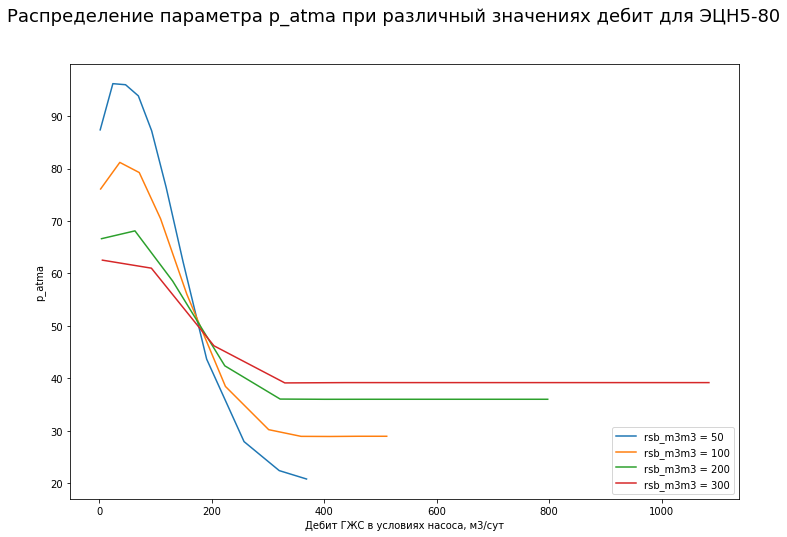

In [16]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'rsb_m3m3', [50, 100, 200, 300], True, 'p_atma', use_q_mix=True )

Видно, что дебит ГЖС в условиях ЭЦН намного больше, чем в поверхностных условиях

И характеристики ЭЦН (на воде) работают с дебитом, поступившим в насос

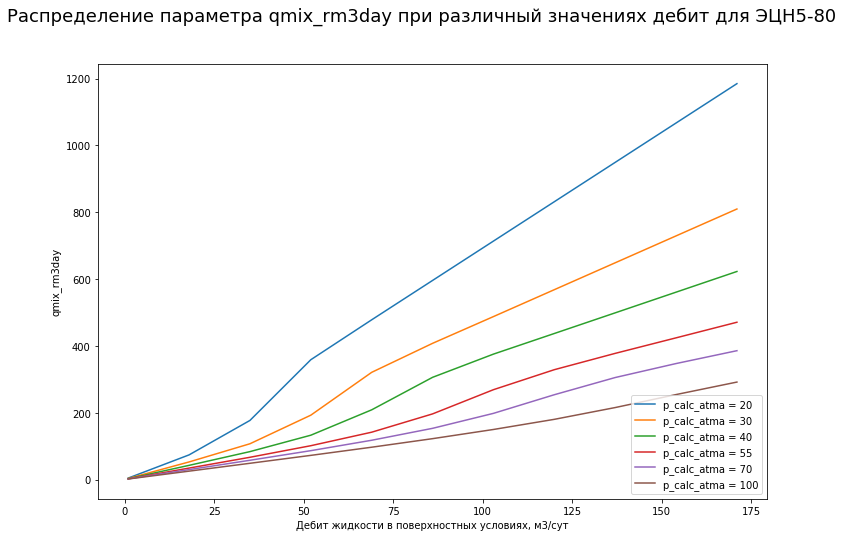

In [17]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'p_calc_atma', [20, 30, 40, 55, 70,100], False, 'qmix_rm3day', 
           result_value_type = 2)

Влияние плотности на развиваемый перепад давления ЭЦН

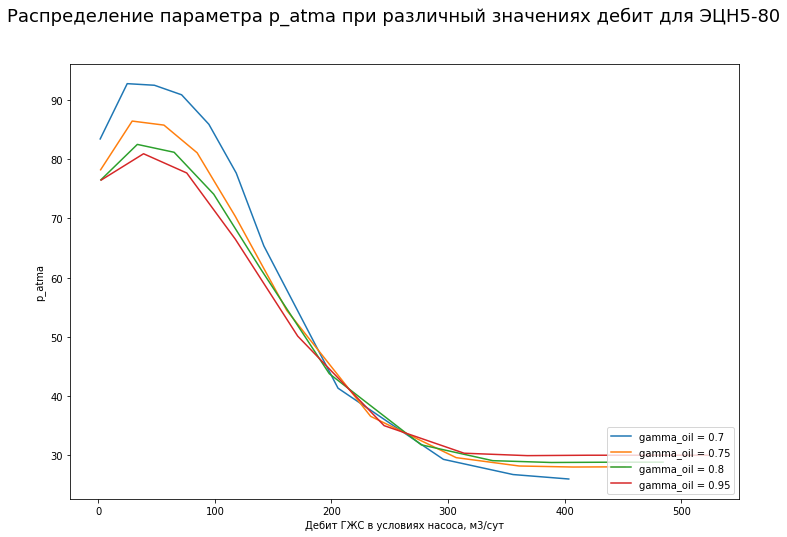

In [18]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'gamma_oil', [0.7, 0.75, 0.8, 0.95], True, 'p_atma', use_q_mix=True)

Влияние частоты на перепад давления

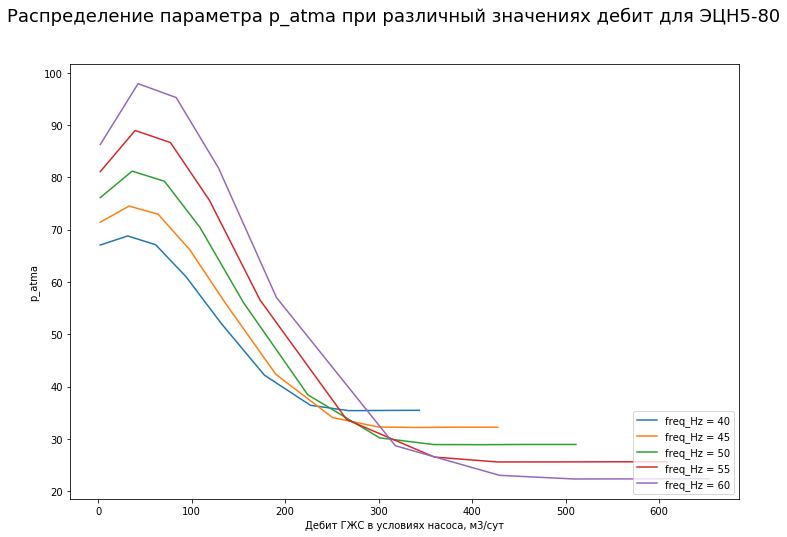

In [19]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'freq_Hz', [40, 45, 50, 55, 60], False, 'p_atma', use_q_mix=True)

Влияние давления на приеме на развиваемый перепад давления ЭЦН

Видно, что при снижении давления на приеме ЭЦН в потоке становится много свободного газа, что негативно сказывается на перекачивающих способностям ЭЦН

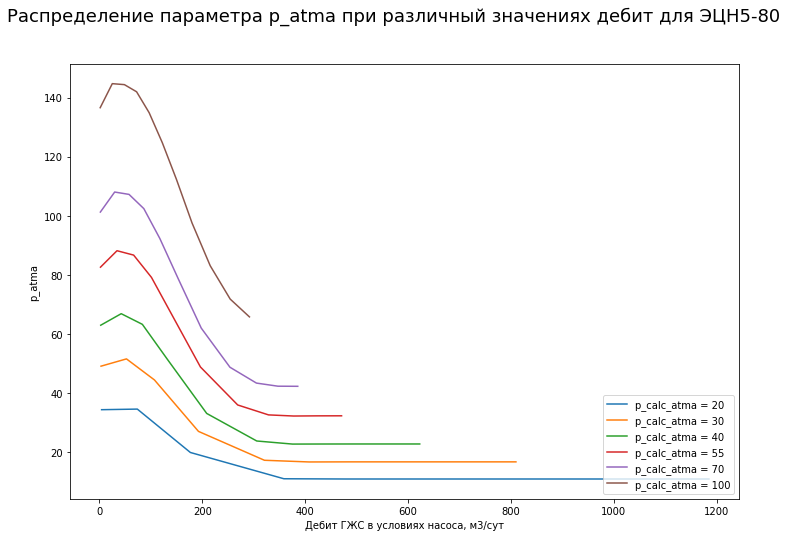

In [20]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'p_calc_atma', [20, 30, 40, 55, 70,100], False, 'p_atma', use_q_mix=True)

Для версии 7.24

```
ESP_gas_correct - деградация по газу:
' 0 - 2 задает значение вручную;
' 10 стандартный ЭЦН (предел 25%);
' 20 ЭЦН с газостабилизирующим модулем (предел 50%);
' 30 ЭЦН с осевым модулем (предел 75%);
' 40 ЭЦН с модифицированным ступенями (предел 40%).
' 110+, тогда модель n-100 применяется ко всем ступеням отдельно
' Предел по доле газа на входе в насос после сепарации
' на основе статьи SPE 117414 (с корректировкой)
' поправка дополнительная к деградации (суммируется).

```

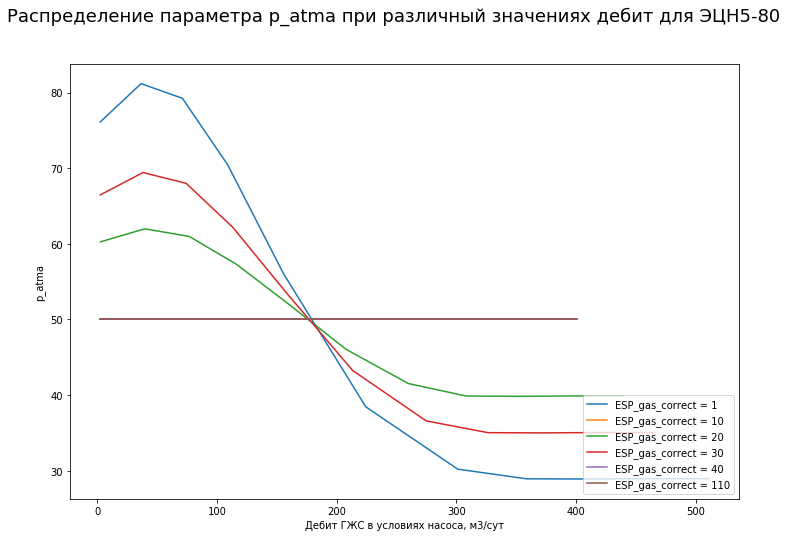

In [21]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'ESP_gas_correct', [1, 10, 20, 30, 40,110], False, 'p_atma', use_q_mix=True)

При большей обводнености ЭЦН работает лучше

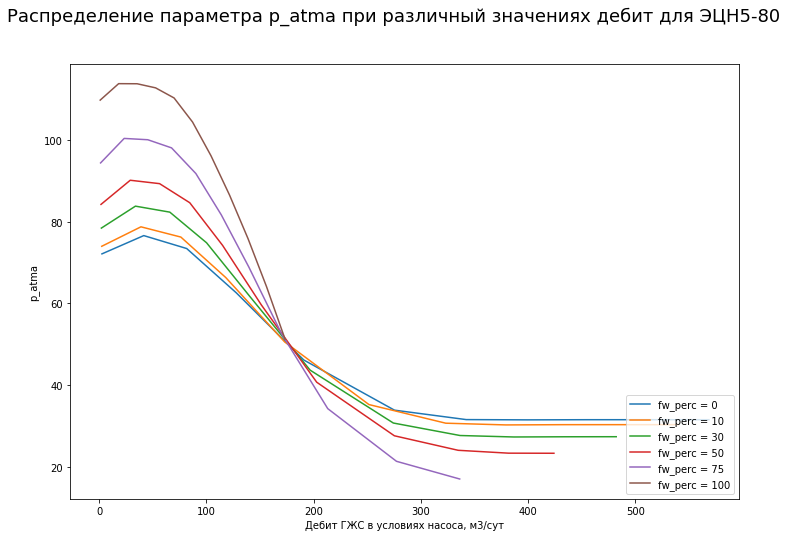

In [22]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'fw_perc', [0, 10, 30,50, 75, 100], False, 'p_atma', use_q_mix=True)

Потребляемая мощность растет за счет плотности жидкости

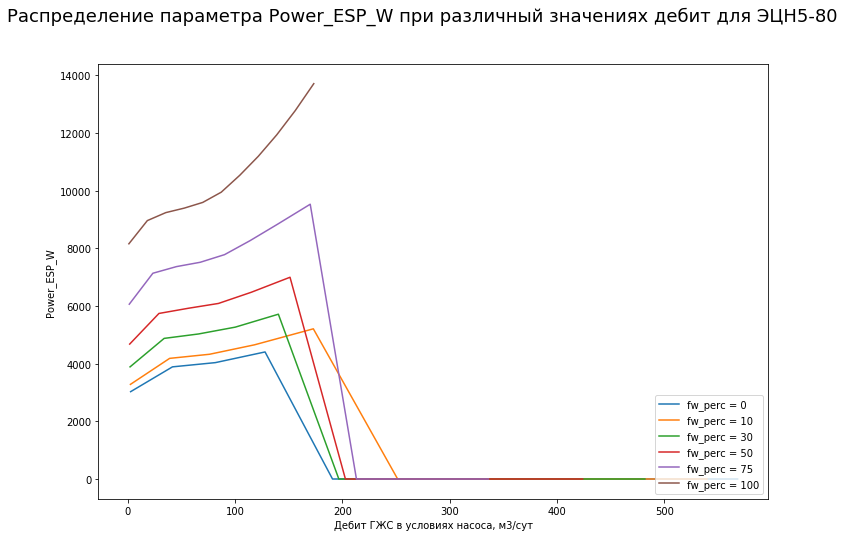

In [23]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'fw_perc', [0, 10, 30,50, 75, 100], False, 'Power_ESP_W', 
            qliq_mult_from_max=1, use_q_mix=True)

Расчет в UniflocVBA температуры в ЭЦН производится через уравнение теплового баланса

Представим, что насос потребляет 100 кВт и его КПД 50% на оптимальном режиме

В данном случае примерно 50 кВт энергии пойдет на нагрев жидкости теми или иными путями

При этом, в крайней левой зоны характеристики, за счет того, что расход жидкости мал и КПД низок, насос может значительно перегреваться

К слову, ПЭД нагревает ГЖС относительно ЭЦН в меньшей степени, т.к. КПД ПЭД высок (около 90%)

Например, если 100 кВт электрической мощности по кабелю пришло к ПЭД, то примерно 10 кВт пойдет на нагрев жидкости, а 90 кВт механической мощности пойдет через вал к ЭЦН

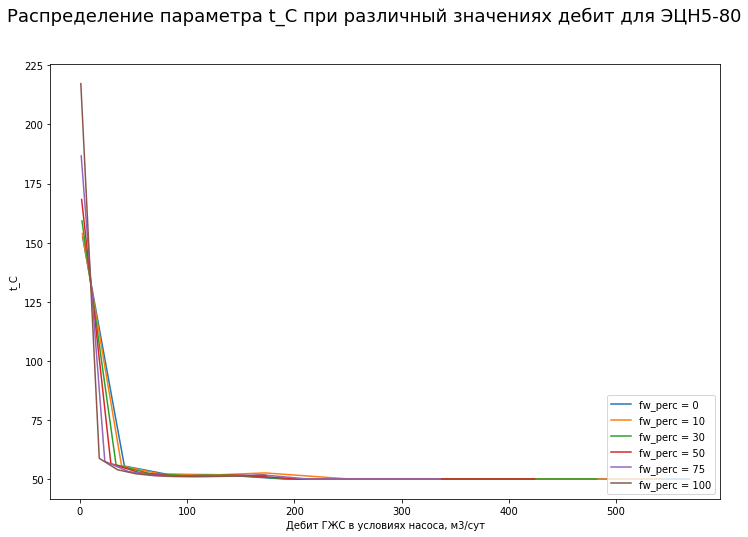

In [24]:
sense_curve(esp_data.copy(), pvt_str_data.copy(), 'fw_perc', [0, 10, 30,50, 75, 100], False, 't_C', 
            use_q_mix=True,
           result_value_type=1)

# Анализ распределения свойств по ступеням

In [25]:
def sense_profile(esp_data, pvt_str_data, parameter_sense, range_sense, pvt_edit=False, parameter_to_plot='p_atma'):
    fig = plt.figure()
    for i in range_sense:
        if pvt_edit:
            pvt_str_data[parameter_sense] = i
            esp_data['str_PVT'] = UniflocVBA.PVT_encode_string(**pvt_str_data)
        else:
            esp_data[parameter_sense] = i
        vba_result = UniflocVBA.ESP_p_atma(**esp_data)
        r = covert_vba_result(vba_result,2)
        plt.plot(r.index, r[parameter_to_plot], label = f"{parameter_sense} = {i}")
    plt.legend(loc='lower right')
    plt.xlabel("Номер ступени")
    plt.ylabel(parameter_to_plot)
    fig.suptitle(f"Распределение параметра {parameter_to_plot} по ступеням для " 
                 f"{UniflocVBA.ESP_name(esp_data['pump_id'])}", fontsize = 18)
    plt.show()

Распределения давления вдоль ЭЦН. Чем больше свободного газа, тем меньший перепад давления развивает каждая ступень

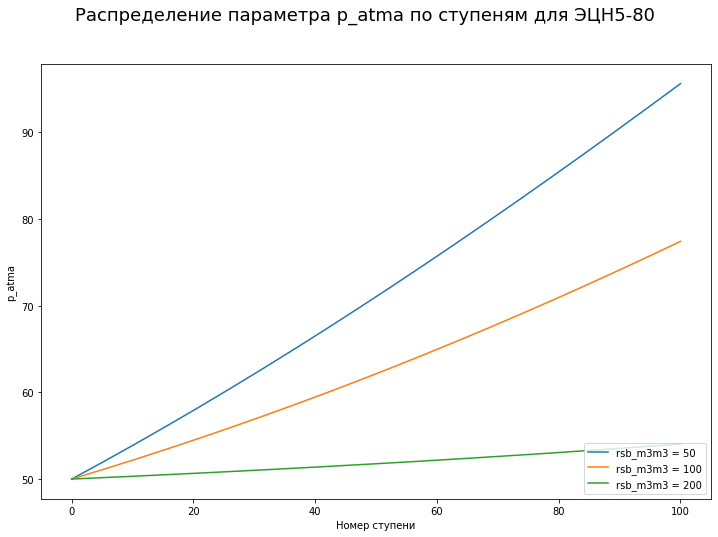

In [26]:
sense_profile(esp_data.copy(), pvt_str_data.copy(), 'rsb_m3m3', [50, 100, 200], True, 'p_atma')

Чем больше обводненность, тем легче работать ЭЦН

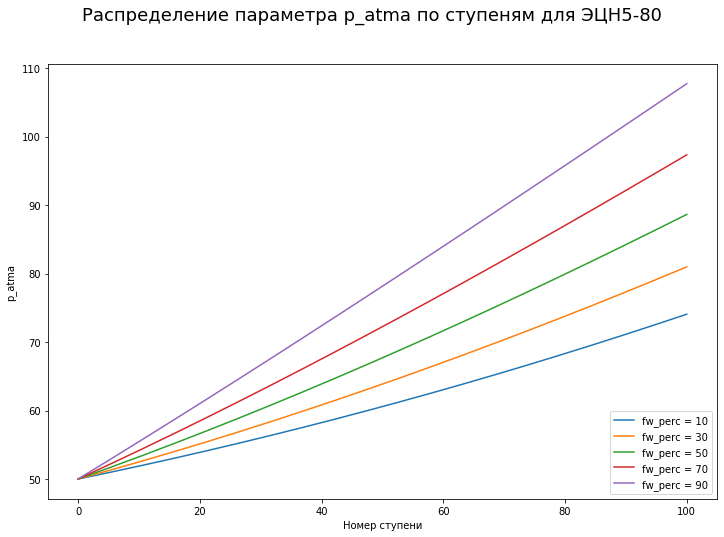

In [27]:
sense_profile(esp_data.copy(), pvt_str_data.copy(), 'fw_perc', range(10, 100, 20), False, 'p_atma')

В модели ЭЦН, используемой в UniflocVBA, в насосе при повышении давления газ растворяется в нефти

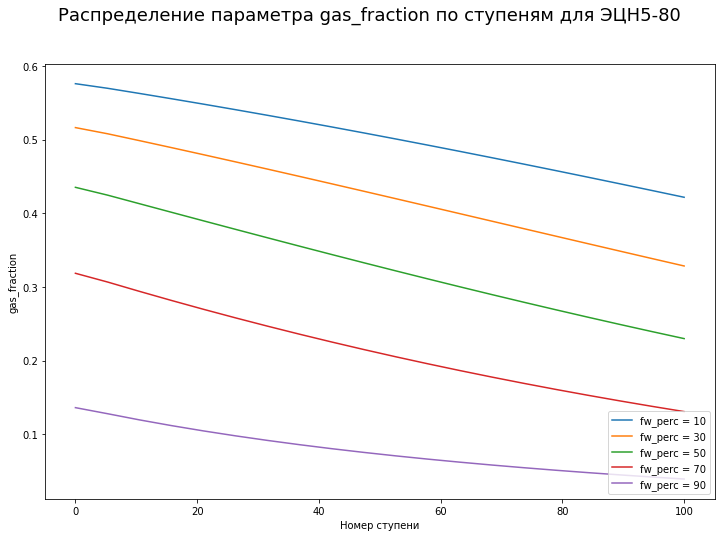

In [28]:
sense_profile(esp_data.copy(), pvt_str_data.copy(), 'fw_perc', range(10, 100, 20), False, 'gas_fraction')